In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
single_train = pd.read_csv("../final_dataset/single/single_train.csv")
single_valid = pd.read_csv("../final_dataset/single/single_valid.csv")
single_test = pd.read_csv("../final_dataset/single/single_test.csv")

In [3]:
feature_columns = single_train.columns[1:-1]

X_single_train = single_train[feature_columns].values
Y_single_train = single_train['Label'].values

X_single_valid = single_valid[feature_columns].values
Y_single_valid = single_valid['Label'].values

X_single_test = single_test[feature_columns].values
Y_single_test = single_test['Label'].values

In [4]:
single_scaler = StandardScaler()

X_single_train = single_scaler.fit_transform(X_single_train)
X_single_valid = single_scaler.transform(X_single_valid)
X_single_test = single_scaler.transform(X_single_test)

Y_single_train = Y_single_train.astype(int)
Y_single_valid = Y_single_valid.astype(int)
Y_single_test = Y_single_test.astype(int)

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

def print_classification_result(result_df, model_name, data_type, y_true, y_pred, y_pred_prob):
    # 정확도
    accuracy = accuracy_score(y_true, y_pred)
    
    # 정밀도 (단일 스칼라 값)
    precision = precision_score(y_true, y_pred, average='weighted')  
    
    # 재현율 (단일 스칼라 값)
    recall = recall_score(y_true, y_pred, average='weighted')  
    
    # F1 점수 (단일 스칼라 값)
    f1 = f1_score(y_true, y_pred, average='weighted')  
    
    # AUC Score 계산
    auc_score = roc_auc_score(y_true, y_pred_prob[:, 1])
    
    # PR Score 계산
    pr_score = average_precision_score(y_true, y_pred_prob[:, 1])
    
    # 결과 저장 (각 지표의 단일 값 저장)
    result_df.loc[len(result_df)] = [
        model_name,
        data_type,
        accuracy,
        precision,
        recall,
        f1,
        auc_score,
        pr_score
    ]


In [6]:
from tensorflow import keras
import tensorflow_addons as tfa

# Transformer 모델에 들어가는 encoder 첫번째
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="LeakyReLU")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    return x + res


# Transformer 모델에 들어가는 encoder 두번째
def transformer_encoder2(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)

    x = keras.layers.Dropout(dropout)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="LeakyReLU")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    return x + res


# Transformer 모델 설계 부분
def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
        n_classes=1,  # n_classes 변수를 함수 내로 이동
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x1 = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    for _ in range(num_transformer_blocks):
        x2 = transformer_encoder2(x, head_size, num_heads, ff_dim, dropout)
    
    x = (0.5 * x1) + (0.5 * x2)
    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="LeakyReLU")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    
    outputs = keras.layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


2024-09-20 22:04:48.477918: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 22:04:48.553137: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 22:04:48.553184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 22:04:48.553194: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 22:04:48.569562: I tensorflow/core/platform/cpu_feature_g

In [7]:
# 데이터 형태 맞추기
X_single_train = X_single_train.reshape((X_single_train.shape[0], X_single_train.shape[1], 1))
X_single_valid = X_single_valid.reshape((X_single_valid.shape[0], X_single_valid.shape[1], 1))
X_single_test= X_single_test.reshape((X_single_test.shape[0], X_single_test.shape[1], 1))

In [8]:
input_shape = (26,1)
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

2024-09-20 22:04:52.018409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31137 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [9]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 

# 모델 학습
history = model.fit(X_single_train, Y_single_train, epochs=50, batch_size=32, validation_data=(X_single_valid, Y_single_valid))

Epoch 1/50


2024-09-20 22:05:03.663203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-09-20 22:05:05.083040: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f913c6c8890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-20 22:05:05.083095: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-20 22:05:05.096773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-20 22:05:05.314514: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 [==============================] - 19s 30ms/step - loss: 0.5116 - accuracy: 0.7395 - val_loss: 0.4826 - val_accuracy: 0.7826
Epoch 2/50
91/91 [==============================] - 2s 21ms/step - loss: 0.4210 - accuracy: 0.7973 - val_loss: 0.4371 - val_accuracy: 0.7814
Epoch 3/50
91/91 [==============================] - 2s 22ms/step - loss: 0.3772 - accuracy: 0.8237 - val_loss: 0.3864 - val_accuracy: 0.8071
Epoch 4/50
91/91 [==============================] - 2s 24ms/step - loss: 0.3451 - accuracy: 0.8368 - val_loss: 0.3576 - val_accuracy: 0.8200
Epoch 5/50
91/91 [==============================] - 2s 21ms/step - loss: 0.3286 - accuracy: 0.8505 - val_loss: 0.3406 - val_accuracy: 0.8347
Epoch 6/50
91/91 [==============================] - 2s 23ms/step - loss: 0.3129 - accuracy: 0.8584 - val_loss: 0.3414 - val_accuracy: 0.8322
Epoch 7/50
91/91 [==============================] - 2s 21ms/step - loss: 0.2956 - accuracy: 0.8715 - val_loss: 0.3347 - val_accuracy: 0.8463
Epoch 8/50
91/91 [=====

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

# 예측
y_pred = model.predict(X_single_train)

# 예측 확률을 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(Y_single_train, y_pred_binary)

# Weighted Precision
weighted_precision = precision_score(Y_single_train, y_pred_binary)

# Weighted Recall
weighted_recall = recall_score(Y_single_train, y_pred_binary)

# Weighted F1 Score
weighted_f1 = f1_score(Y_single_train, y_pred_binary)

# AUC Score
auc_score = roc_auc_score(Y_single_train, y_pred)

# PR Curve의 평균 정밀도 점수 계산
pr_score = average_precision_score(Y_single_train, y_pred)

print("---------------------------train--------------------------")
print(f'Accuracy: {accuracy}')
print(f'Precision: {weighted_precision}')
print(f'Recall: {weighted_recall}')
print(f'F1 Score: {weighted_f1}')
print(f'AUC Score: {auc_score}')
print(f'PR Score: {pr_score}')


91/91 [==============================] - 1s 4ms/step
---------------------------train--------------------------
Accuracy: 0.9309278350515464
Precision: 0.9231378763866878
Recall: 0.9180457052797478
F1 Score: 0.9205847491110233
AUC Score: 0.9798994347466348
PR Score: 0.976235907569211


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

# 예측
y_pred = model.predict(X_single_valid)

# 예측 확률을 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(Y_single_valid, y_pred_binary)

# Weighted Precision
weighted_precision = precision_score(Y_single_valid, y_pred_binary)

# Weighted Recall
weighted_recall = recall_score(Y_single_valid, y_pred_binary)

# Weighted F1 Score
weighted_f1 = f1_score(Y_single_valid, y_pred_binary)

# AUC Score
auc_score = roc_auc_score(Y_single_valid, y_pred)

# PR Curve의 평균 정밀도 점수 계산
pr_score = average_precision_score(Y_single_valid, y_pred)

print("---------------------------valid--------------------------")
print(f'Accuracy: {accuracy}')
print(f'Precision: {weighted_precision}')
print(f'Recall: {weighted_recall}')
print(f'F1 Score: {weighted_f1}')
print(f'AUC Score: {auc_score}')
print(f'PR Score: {pr_score}')


52/52 [==============================] - 0s 4ms/step
---------------------------valid--------------------------
Accuracy: 0.8873239436619719
Precision: 0.8147668393782384
Recall: 0.9388059701492537
F1 Score: 0.8723994452149791
AUC Score: 0.9585762774910495
PR Score: 0.9364447900288604


In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

# 예측
y_pred = model.predict(X_single_test)

# 예측 확률을 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(Y_single_test, y_pred_binary)

# Weighted Precision
weighted_precision = precision_score(Y_single_test, y_pred_binary)

# Weighted Recall
weighted_recall = recall_score(Y_single_test, y_pred_binary)

# Weighted F1 Score
weighted_f1 = f1_score(Y_single_test, y_pred_binary)

# AUC Score
auc_score = roc_auc_score(Y_single_test, y_pred)

# PR Curve의 평균 정밀도 점수 계산
pr_score = average_precision_score(Y_single_test, y_pred)

print("---------------------------test--------------------------")
print(f'Accuracy: {accuracy}')
print(f'Precision: {weighted_precision}')
print(f'Recall: {weighted_recall}')
print(f'F1 Score: {weighted_f1}')
print(f'AUC Score: {auc_score}')
print(f'PR Score: {pr_score}')


61/61 [==============================] - 1s 10ms/step
---------------------------test--------------------------
Accuracy: 0.8192584963954685
Precision: 0.7891949152542372
Recall: 0.830546265328874
F1 Score: 0.8093427485062467
AUC Score: 0.9032340657054616
PR Score: 0.8676966997772927


In [39]:
# 혼동 행렬 시각화를 위한 함수 정의
def plot_confusion_matrix(model_name, true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

61/61 [==============================] - 0s 6ms/step


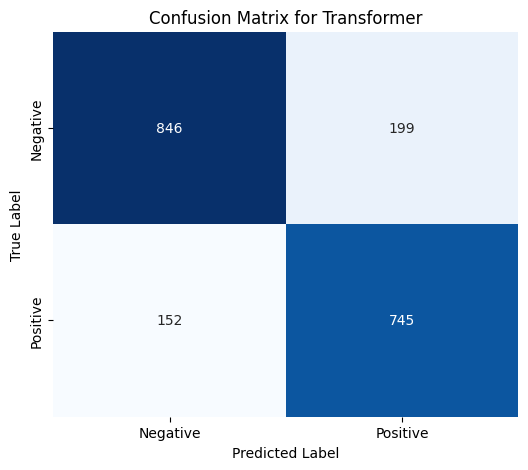

In [40]:
# 테스트 데이터에 대한 예측
test_pred_prob = model.predict(X_single_test)  # 확률값 반환
    
# 확률을 클래스 레이블로 변환 (0.5 임계값 사용)
test_pred = (test_pred_prob >= 0.5).astype(int)

# 혼동 행렬 시각화
plot_confusion_matrix("Transformer", Y_single_test, test_pred)

In [13]:
transformer_pred_prob = model.predict(X_single_test)
np.save('../ml_models/pred_prob/transformer_pred_prob_single.npy', transformer_pred_prob)  # .npy 파일로 저장

61/61 [==============================] - 0s 6ms/step


In [14]:
test_1 = pd.read_csv("../final_dataset/each_test/single/A_S_11.csv")
test_2 = pd.read_csv("../final_dataset/each_test/single/B_S_11.csv")
test_3 = pd.read_csv("../final_dataset/each_test/single/C_S_11.csv")
test_4 = pd.read_csv("../final_dataset/each_test/single/D_S_11.csv")
test_5 = pd.read_csv("../final_dataset/each_test/single/E_S_11.csv")
test_6 = pd.read_csv("../final_dataset/each_test/single/F_S_11.csv")
test_7 = pd.read_csv("../final_dataset/each_test/single/G_S_11.csv")
test_8 = pd.read_csv("../final_dataset/each_test/single/H_S_11.csv")
test_9 = pd.read_csv("../final_dataset/each_test/single/I_S_11.csv")
test_10 = pd.read_csv("../final_dataset/each_test/single/J_S_11.csv")

In [15]:
# feature_columns 정의
feature_columns = test_1.columns[1:-1]  # 모든 test 파일에 동일한 컬럼 구조라고 가정

# 각 test 데이터에 대해 feature와 label 추출
X_test_1 = test_1[feature_columns].values
Y_test_1 = test_1['Label'].values

X_test_2 = test_2[feature_columns].values
Y_test_2 = test_2['Label'].values

X_test_3 = test_3[feature_columns].values
Y_test_3 = test_3['Label'].values

X_test_4 = test_4[feature_columns].values
Y_test_4 = test_4['Label'].values

X_test_5 = test_5[feature_columns].values
Y_test_5 = test_5['Label'].values

X_test_6 = test_6[feature_columns].values
Y_test_6 = test_6['Label'].values

X_test_7 = test_7[feature_columns].values
Y_test_7 = test_7['Label'].values

X_test_8 = test_8[feature_columns].values
Y_test_8 = test_8['Label'].values

X_test_9 = test_9[feature_columns].values
Y_test_9 = test_9['Label'].values

X_test_10 = test_10[feature_columns].values
Y_test_10 = test_10['Label'].values

In [16]:
# Scaler 적용 및 데이터 형 변환을 처리하는 함수 정의
def process_test_data(X_test, Y_test, scaler):
    # 데이터 스케일링
    X_test_scaled = scaler.transform(X_test)
    
    # int 타입으로 변환
    Y_test = Y_test.astype(int)
    
    return X_test_scaled, Y_test


In [17]:
# X_single_train, X_single_valid, X_single_test의 스케일러로 test 데이터 변환
X_test_1, Y_test_1 = process_test_data(X_test_1, Y_test_1, single_scaler)
X_test_2, Y_test_2 = process_test_data(X_test_2, Y_test_2, single_scaler)
X_test_3, Y_test_3 = process_test_data(X_test_3, Y_test_3, single_scaler)
X_test_4, Y_test_4 = process_test_data(X_test_4, Y_test_4, single_scaler)
X_test_5, Y_test_5 = process_test_data(X_test_5, Y_test_5, single_scaler)
X_test_6, Y_test_6 = process_test_data(X_test_6, Y_test_6, single_scaler)
X_test_7, Y_test_7 = process_test_data(X_test_7, Y_test_7, single_scaler)
X_test_8, Y_test_8 = process_test_data(X_test_8, Y_test_8, single_scaler)
X_test_9, Y_test_9 = process_test_data(X_test_9, Y_test_9, single_scaler)
X_test_10, Y_test_10 = process_test_data(X_test_10, Y_test_10, single_scaler)

In [18]:
import os

# 모델을 사용하여 예측 및 점프수 계산을 반복적으로 수행하는 함수
def process_and_visualize(test_data, Y_test, model, model_name, test_name, output_dir):
    
    test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
    # 테스트 데이터에 대한 예측
    predictions = model.predict(test_data)
    
    # 이동 평균을 계산하여 예측값 부드럽게 만들기
    smoothed_predictions = np.convolve(predictions.squeeze(), np.ones(5)/5, mode='same')
    
    # 테스트 데이터에 대한 예측 결과를 바이너리 형태로 변환
    binary_predictions = (smoothed_predictions > 0.5).astype(int)
    
    # 0에서 1로 바뀌는 구간에서 줄넘기 개수 카운트
    jump_count = np.sum(np.diff(binary_predictions.flatten()) > 0)
    
    # 예측 결과 시각화
    plt.plot(Y_test, label='Actual')
    plt.plot(binary_predictions.flatten(), label='Predicted')
    plt.title(f'Actual vs Predicted for {test_name} player using {model_name}')  
    plt.xlabel('Data Point')
    plt.ylabel('Label')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'{model_name}_predictions_{test_name}.png'))
    plt.close()  # 현재 플롯 닫기



In [19]:
test_data_list = [
    (X_test_1, Y_test_1, "A"),
    (X_test_2, Y_test_2, "B"),
    (X_test_3, Y_test_3, "C"),
    (X_test_4, Y_test_4, "D"),
    (X_test_5, Y_test_5, "E"),
    (X_test_6, Y_test_6, "F"),
    (X_test_7, Y_test_7, "G"),
    (X_test_8, Y_test_8, "H"),
    (X_test_9, Y_test_9, "I"),
    (X_test_10, Y_test_10, "J")
]

In [20]:
# 결과를 저장할 디렉토리 생성
output_dir = '../single_model_predictions'

  
# 각 테스트 데이터에 대해 process_and_visualize 호출
for test_data, Y_test, test_name in test_data_list:
    # 예측 결과 시각화 및 이미지로 저장
    process_and_visualize(test_data, Y_test, model, "Transformer", test_name, output_dir)
        
        

6/6 [==============================] - 0s 11ms/step


In [22]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 3D 배열을 2D 배열로 변환
X_single_test_reshaped = X_single_test.reshape(X_single_test.shape[0], -1)  # (n_samples, n_timesteps * n_features)

def transformer_predict(X):
    # X가 2D 배열일 경우 3D 배열로 변환
    X_reshaped = np.expand_dims(X, axis=2)  # (n_samples, n_features)에서 (n_samples, n_features, 1)로 변환
    return model.predict(X_reshaped)

# KMeans를 사용하여 배경 데이터 샘플링
background_samples = shap.kmeans(X_single_test_reshaped, k=20)  # K=100으로 샘플 수를 줄임

# KernelExplainer 생성
explainer = shap.KernelExplainer(transformer_predict, background_samples)

# 테스트 데이터에 대한 SHAP 값 추출
shap_values = explainer.shap_values(X_single_test_reshaped, nsamples=100)



/root/anaconda3/envs/jw_tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 [==============================] - 0s 67ms/step


  0%|          | 0/1942 [00:00<?, ?it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 1/1942 [00:00<20:16,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 2/1942 [00:01<18:04,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 3/1942 [00:01<18:18,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 4/1942 [00:02<19:07,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 5/1942 [00:02<18:29,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 6/1942 [00:03<19:34,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 7/1942 [00:04<18:49,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 8/1942 [00:04<18:40,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 9/1942 [00:05<18:28,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 10/1942 [00:05<18:42,  1.72it/s]

63/63 [==============================] - 0s 6ms/step


  1%|          | 11/1942 [00:06<21:34,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 12/1942 [00:07<20:26,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 13/1942 [00:07<19:11,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 14/1942 [00:08<18:54,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 15/1942 [00:08<19:01,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 16/1942 [00:09<21:20,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 17/1942 [00:10<20:10,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 18/1942 [00:10<19:29,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 19/1942 [00:11<18:50,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 20/1942 [00:12<21:14,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 21/1942 [00:12<20:42,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 22/1942 [00:13<19:46,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 23/1942 [00:13<18:56,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 24/1942 [00:14<18:30,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


  1%|▏         | 25/1942 [00:15<20:57,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


  1%|▏         | 26/1942 [00:16<22:19,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


  1%|▏         | 27/1942 [00:16<21:05,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


  1%|▏         | 28/1942 [00:17<20:04,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  1%|▏         | 29/1942 [00:17<19:09,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 30/1942 [00:18<20:00,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 31/1942 [00:19<19:13,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 32/1942 [00:19<21:18,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 33/1942 [00:20<20:02,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 34/1942 [00:21<22:28,  1.41it/s]

63/63 [==============================] - 0s 6ms/step


  2%|▏         | 35/1942 [00:21<21:11,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 36/1942 [00:22<20:18,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 37/1942 [00:22<19:26,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 38/1942 [00:23<19:07,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 39/1942 [00:24<19:02,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 40/1942 [00:24<18:09,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 41/1942 [00:25<18:06,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 42/1942 [00:25<17:53,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 43/1942 [00:26<20:43,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 44/1942 [00:27<23:49,  1.33it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 45/1942 [00:28<25:25,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 46/1942 [00:29<23:23,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 47/1942 [00:29<21:45,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 48/1942 [00:30<20:54,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 49/1942 [00:30<19:47,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 50/1942 [00:31<18:57,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 51/1942 [00:31<18:32,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 52/1942 [00:32<18:03,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 53/1942 [00:33<19:27,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 54/1942 [00:33<18:51,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 55/1942 [00:34<18:17,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 56/1942 [00:34<17:45,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 57/1942 [00:35<17:51,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 58/1942 [00:36<20:26,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 59/1942 [00:36<19:47,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 60/1942 [00:37<21:52,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 61/1942 [00:38<20:16,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 62/1942 [00:38<19:33,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 63/1942 [00:39<18:50,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 64/1942 [00:39<18:00,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 65/1942 [00:40<20:41,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 66/1942 [00:41<19:32,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 67/1942 [00:42<22:30,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▎         | 68/1942 [00:42<20:58,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▎         | 69/1942 [00:43<19:40,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▎         | 70/1942 [00:44<21:28,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▎         | 71/1942 [00:44<20:20,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▎         | 72/1942 [00:45<19:54,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 73/1942 [00:45<19:01,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 74/1942 [00:46<18:28,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 75/1942 [00:46<17:55,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 76/1942 [00:47<17:30,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 77/1942 [00:47<17:09,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 78/1942 [00:48<17:53,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 79/1942 [00:49<17:19,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 80/1942 [00:49<20:02,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 81/1942 [00:50<19:05,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 82/1942 [00:51<21:49,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 83/1942 [00:51<20:13,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 84/1942 [00:52<19:16,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 85/1942 [00:53<21:08,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 86/1942 [00:53<20:01,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 87/1942 [00:54<19:42,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 88/1942 [00:55<21:29,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 89/1942 [00:55<20:00,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 90/1942 [00:56<19:35,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 91/1942 [00:57<19:08,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 92/1942 [00:57<18:58,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 93/1942 [00:58<18:37,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 94/1942 [00:59<21:30,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 95/1942 [00:59<20:10,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 96/1942 [01:00<19:06,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 97/1942 [01:00<18:34,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 98/1942 [01:01<18:20,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 99/1942 [01:01<17:41,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 100/1942 [01:02<17:15,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 101/1942 [01:02<16:32,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 102/1942 [01:03<16:51,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 103/1942 [01:04<16:55,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 104/1942 [01:04<16:52,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 105/1942 [01:05<16:48,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 106/1942 [01:05<17:02,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 107/1942 [01:06<16:45,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 108/1942 [01:06<16:30,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 109/1942 [01:07<17:04,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 110/1942 [01:07<17:03,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 111/1942 [01:08<17:01,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 112/1942 [01:09<16:54,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 113/1942 [01:09<17:24,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 114/1942 [01:10<17:43,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 115/1942 [01:10<17:00,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 116/1942 [01:11<19:29,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 117/1942 [01:12<18:59,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 118/1942 [01:12<18:03,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 119/1942 [01:13<17:20,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 120/1942 [01:13<17:01,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 121/1942 [01:14<17:19,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▋         | 122/1942 [01:14<16:38,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▋         | 123/1942 [01:15<16:25,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▋         | 124/1942 [01:15<16:17,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▋         | 125/1942 [01:16<18:46,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▋         | 126/1942 [01:17<18:07,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 127/1942 [01:18<19:10,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 128/1942 [01:18<18:11,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 129/1942 [01:19<17:13,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 130/1942 [01:19<17:22,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 131/1942 [01:20<17:13,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 132/1942 [01:20<17:14,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 133/1942 [01:21<17:19,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 134/1942 [01:21<17:18,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 135/1942 [01:22<19:40,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 136/1942 [01:23<21:32,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 137/1942 [01:24<22:51,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 138/1942 [01:24<20:20,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 139/1942 [01:25<19:13,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 140/1942 [01:26<18:33,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 141/1942 [01:26<18:04,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 142/1942 [01:27<17:22,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 143/1942 [01:27<16:47,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 144/1942 [01:28<16:21,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 145/1942 [01:29<18:59,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 146/1942 [01:29<18:30,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 147/1942 [01:30<18:18,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 148/1942 [01:30<17:38,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 149/1942 [01:31<17:58,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 150/1942 [01:31<17:29,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 151/1942 [01:32<19:20,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 152/1942 [01:33<18:25,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 153/1942 [01:33<17:21,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 154/1942 [01:34<16:48,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 155/1942 [01:34<16:25,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 156/1942 [01:35<16:10,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 157/1942 [01:35<16:05,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 158/1942 [01:36<16:02,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 159/1942 [01:36<15:30,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 160/1942 [01:37<18:19,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 161/1942 [01:38<17:06,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 162/1942 [01:38<16:18,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 163/1942 [01:39<16:12,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 164/1942 [01:39<15:50,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 165/1942 [01:40<15:20,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▊         | 166/1942 [01:40<15:40,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▊         | 167/1942 [01:41<16:05,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▊         | 168/1942 [01:42<17:25,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▊         | 169/1942 [01:42<16:45,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 170/1942 [01:43<19:11,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 171/1942 [01:44<18:44,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 172/1942 [01:44<18:09,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 173/1942 [01:45<17:33,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 174/1942 [01:45<17:28,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 175/1942 [01:46<19:30,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 176/1942 [01:47<19:29,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 177/1942 [01:47<18:27,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 178/1942 [01:48<17:52,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 179/1942 [01:49<19:51,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 180/1942 [01:49<18:22,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 181/1942 [01:50<21:16,  1.38it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 182/1942 [01:51<19:39,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 183/1942 [01:52<21:18,  1.38it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 184/1942 [01:52<19:11,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 185/1942 [01:53<21:25,  1.37it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 186/1942 [01:53<19:42,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 187/1942 [01:54<18:21,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 188/1942 [01:54<17:23,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 189/1942 [01:55<17:03,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 190/1942 [01:56<19:33,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 191/1942 [01:56<18:01,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 192/1942 [01:57<17:28,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 193/1942 [01:57<16:52,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 194/1942 [01:58<16:41,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 10%|█         | 195/1942 [01:59<19:06,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 196/1942 [01:59<18:08,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 197/1942 [02:00<17:19,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 198/1942 [02:01<19:14,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 199/1942 [02:01<17:59,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 200/1942 [02:02<17:08,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 10%|█         | 201/1942 [02:03<19:26,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 202/1942 [02:03<17:52,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 203/1942 [02:04<16:58,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 204/1942 [02:04<16:21,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 205/1942 [02:05<16:10,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 206/1942 [02:05<16:14,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 207/1942 [02:06<15:51,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 208/1942 [02:07<18:41,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 209/1942 [02:07<17:52,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 210/1942 [02:08<16:59,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 211/1942 [02:08<16:41,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 212/1942 [02:09<16:26,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 213/1942 [02:09<15:33,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 214/1942 [02:10<16:36,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 215/1942 [02:11<15:59,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 216/1942 [02:11<18:22,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 217/1942 [02:12<20:10,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 218/1942 [02:13<18:05,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█▏        | 219/1942 [02:13<17:24,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█▏        | 220/1942 [02:14<16:47,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█▏        | 221/1942 [02:14<16:22,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█▏        | 222/1942 [02:15<16:09,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█▏        | 223/1942 [02:15<16:43,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 224/1942 [02:16<16:28,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 225/1942 [02:17<15:57,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 226/1942 [02:17<15:50,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 227/1942 [02:18<15:35,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 228/1942 [02:18<15:08,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 229/1942 [02:19<15:07,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 230/1942 [02:19<15:05,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 231/1942 [02:20<15:29,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 232/1942 [02:20<15:05,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 233/1942 [02:21<16:49,  1.69it/s]

63/63 [==============================] - 0s 6ms/step


 12%|█▏        | 234/1942 [02:22<18:54,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 235/1942 [02:23<20:13,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 236/1942 [02:23<18:30,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 237/1942 [02:24<17:12,  1.65it/s]

63/63 [==============================] - 0s 6ms/step


 12%|█▏        | 238/1942 [02:24<19:17,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 239/1942 [02:25<18:20,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 240/1942 [02:26<20:03,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 241/1942 [02:26<18:39,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 242/1942 [02:27<16:49,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 243/1942 [02:27<16:12,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 244/1942 [02:28<17:11,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 245/1942 [02:29<19:00,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 246/1942 [02:29<17:43,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 247/1942 [02:30<16:52,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 248/1942 [02:31<17:20,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 249/1942 [02:31<16:34,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 250/1942 [02:32<16:36,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 251/1942 [02:32<16:08,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 252/1942 [02:33<15:45,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 253/1942 [02:33<15:11,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 254/1942 [02:34<15:26,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 255/1942 [02:34<15:06,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 256/1942 [02:35<15:01,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 257/1942 [02:35<14:51,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 258/1942 [02:36<15:28,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 259/1942 [02:37<17:49,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 260/1942 [02:37<17:05,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 261/1942 [02:38<19:16,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 262/1942 [02:39<17:41,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▎        | 263/1942 [02:39<17:24,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▎        | 264/1942 [02:40<16:34,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▎        | 265/1942 [02:41<16:41,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▎        | 266/1942 [02:41<16:33,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▎        | 267/1942 [02:42<18:29,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 268/1942 [02:42<17:09,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 269/1942 [02:43<17:53,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 270/1942 [02:44<16:59,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 271/1942 [02:44<16:47,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 272/1942 [02:45<15:55,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 273/1942 [02:46<19:31,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 274/1942 [02:46<18:17,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 275/1942 [02:47<17:29,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 276/1942 [02:47<16:07,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 277/1942 [02:48<15:48,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 278/1942 [02:48<15:27,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 279/1942 [02:49<15:00,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 280/1942 [02:50<15:47,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 281/1942 [02:50<17:36,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 282/1942 [02:51<16:54,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 283/1942 [02:51<16:16,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 284/1942 [02:52<15:28,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 285/1942 [02:53<15:57,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 286/1942 [02:53<15:25,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 287/1942 [02:54<15:19,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 288/1942 [02:54<15:06,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 289/1942 [02:55<14:49,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 290/1942 [02:55<15:30,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 291/1942 [02:56<15:06,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 292/1942 [02:56<14:54,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 293/1942 [02:57<14:40,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 294/1942 [02:57<14:55,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 295/1942 [02:58<14:54,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 296/1942 [02:59<14:53,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 297/1942 [02:59<14:53,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 298/1942 [03:00<14:49,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 299/1942 [03:00<14:50,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 300/1942 [03:01<14:42,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 301/1942 [03:01<15:20,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 302/1942 [03:02<15:30,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 303/1942 [03:02<15:40,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 304/1942 [03:03<15:03,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 305/1942 [03:03<14:59,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 306/1942 [03:04<15:04,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 307/1942 [03:05<14:39,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 308/1942 [03:05<17:01,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 309/1942 [03:06<18:34,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 310/1942 [03:07<17:18,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 311/1942 [03:07<16:42,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 312/1942 [03:08<18:34,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 313/1942 [03:09<17:06,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 314/1942 [03:09<16:19,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 315/1942 [03:10<15:25,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▋        | 316/1942 [03:10<15:35,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▋        | 317/1942 [03:11<15:23,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▋        | 318/1942 [03:11<14:51,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▋        | 319/1942 [03:12<17:04,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▋        | 320/1942 [03:13<16:08,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 321/1942 [03:13<15:13,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 322/1942 [03:14<15:00,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 323/1942 [03:14<14:36,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 324/1942 [03:15<14:25,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 325/1942 [03:15<14:58,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 326/1942 [03:16<14:33,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 327/1942 [03:16<14:18,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 328/1942 [03:17<14:42,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 329/1942 [03:17<14:42,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 330/1942 [03:18<14:38,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 331/1942 [03:19<14:33,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 332/1942 [03:19<17:20,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 333/1942 [03:20<16:04,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 334/1942 [03:20<16:01,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 335/1942 [03:21<15:24,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 336/1942 [03:22<14:52,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 337/1942 [03:22<15:00,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 338/1942 [03:23<14:47,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 339/1942 [03:23<14:40,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 340/1942 [03:24<14:36,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 341/1942 [03:24<14:42,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 342/1942 [03:25<15:29,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 343/1942 [03:25<14:49,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 344/1942 [03:26<14:29,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 345/1942 [03:26<14:32,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 346/1942 [03:27<14:26,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 347/1942 [03:28<14:12,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 348/1942 [03:28<14:38,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 349/1942 [03:29<13:49,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 350/1942 [03:29<14:09,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 351/1942 [03:30<14:03,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 352/1942 [03:31<16:27,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 353/1942 [03:31<15:52,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 354/1942 [03:32<15:15,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 355/1942 [03:32<14:45,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 356/1942 [03:33<14:37,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 357/1942 [03:33<14:32,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 358/1942 [03:34<16:49,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 359/1942 [03:35<15:54,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▊        | 360/1942 [03:35<15:29,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▊        | 361/1942 [03:36<15:05,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▊        | 362/1942 [03:36<15:05,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▊        | 363/1942 [03:37<15:09,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▊        | 364/1942 [03:37<15:42,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 365/1942 [03:38<15:12,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 366/1942 [03:38<14:39,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 367/1942 [03:39<14:34,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 368/1942 [03:40<14:32,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 369/1942 [03:40<16:43,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 370/1942 [03:41<15:29,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 371/1942 [03:41<14:49,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 372/1942 [03:42<14:03,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 373/1942 [03:42<14:03,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 374/1942 [03:43<13:54,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 375/1942 [03:43<13:49,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 376/1942 [03:44<14:10,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 377/1942 [03:45<13:49,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 378/1942 [03:45<13:18,  1.96it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 379/1942 [03:46<13:33,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 380/1942 [03:46<14:46,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 381/1942 [03:47<14:41,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 382/1942 [03:47<14:25,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 383/1942 [03:48<14:12,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 384/1942 [03:48<14:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 385/1942 [03:49<13:44,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 386/1942 [03:50<14:41,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 387/1942 [03:50<14:29,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 388/1942 [03:51<14:08,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 20%|██        | 389/1942 [03:51<14:09,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 390/1942 [03:52<14:00,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 391/1942 [03:53<16:34,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 392/1942 [03:53<18:24,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 393/1942 [03:54<19:27,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 394/1942 [03:55<17:21,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 395/1942 [03:55<15:59,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 20%|██        | 396/1942 [03:56<15:18,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 397/1942 [03:56<14:27,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 398/1942 [03:57<14:04,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 399/1942 [03:57<14:00,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 400/1942 [03:58<13:41,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 401/1942 [03:58<13:51,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 402/1942 [03:59<13:26,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 403/1942 [03:59<13:28,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 404/1942 [04:00<13:07,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 405/1942 [04:00<13:27,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 406/1942 [04:01<13:48,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 407/1942 [04:02<13:43,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 408/1942 [04:02<14:29,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 409/1942 [04:03<14:22,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 410/1942 [04:03<14:15,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 411/1942 [04:04<14:21,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 412/1942 [04:04<13:43,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 413/1942 [04:05<13:47,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 414/1942 [04:05<13:57,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██▏       | 415/1942 [04:06<13:45,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██▏       | 416/1942 [04:06<13:31,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 417/1942 [04:07<13:34,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 418/1942 [04:08<13:27,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 419/1942 [04:08<13:33,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 420/1942 [04:09<13:36,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 421/1942 [04:09<13:56,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 422/1942 [04:10<13:41,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 423/1942 [04:10<13:38,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 424/1942 [04:11<14:23,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 425/1942 [04:11<14:29,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 426/1942 [04:12<14:17,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 427/1942 [04:13<17:08,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 428/1942 [04:14<18:13,  1.38it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 429/1942 [04:14<16:34,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 430/1942 [04:15<16:02,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 431/1942 [04:15<15:17,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 432/1942 [04:16<14:42,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 433/1942 [04:16<14:24,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 434/1942 [04:17<14:23,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 435/1942 [04:18<14:03,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 436/1942 [04:18<13:44,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 437/1942 [04:19<13:28,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 438/1942 [04:19<13:57,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 439/1942 [04:20<13:46,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 440/1942 [04:20<13:28,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 441/1942 [04:21<15:50,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 442/1942 [04:22<14:55,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 443/1942 [04:22<14:42,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 444/1942 [04:23<14:22,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 445/1942 [04:23<13:43,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 446/1942 [04:24<13:20,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 447/1942 [04:24<13:33,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 448/1942 [04:25<15:45,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 449/1942 [04:26<15:06,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 450/1942 [04:26<14:55,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 451/1942 [04:27<14:02,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 452/1942 [04:27<13:49,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 453/1942 [04:28<14:07,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 454/1942 [04:28<14:16,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 455/1942 [04:29<14:04,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 456/1942 [04:30<13:34,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▎       | 457/1942 [04:30<13:29,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▎       | 458/1942 [04:31<15:09,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▎       | 459/1942 [04:32<17:12,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▎       | 460/1942 [04:32<15:40,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▎       | 461/1942 [04:33<14:41,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 462/1942 [04:33<13:58,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 463/1942 [04:34<14:02,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 464/1942 [04:34<13:33,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 465/1942 [04:35<12:54,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 466/1942 [04:35<13:04,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 467/1942 [04:36<12:52,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 468/1942 [04:36<12:30,  1.96it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 469/1942 [04:37<12:51,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 470/1942 [04:37<12:46,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 471/1942 [04:38<15:16,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 472/1942 [04:39<14:43,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 473/1942 [04:39<13:54,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 474/1942 [04:40<15:54,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 475/1942 [04:41<14:48,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▍       | 476/1942 [04:41<14:16,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 477/1942 [04:42<13:48,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 478/1942 [04:42<13:42,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▍       | 479/1942 [04:43<15:51,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 480/1942 [04:44<15:01,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 481/1942 [04:44<14:20,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 482/1942 [04:45<13:50,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▍       | 483/1942 [04:45<13:52,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▍       | 484/1942 [04:46<15:53,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 485/1942 [04:47<14:51,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 486/1942 [04:47<14:24,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 487/1942 [04:48<14:23,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 488/1942 [04:48<13:40,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 489/1942 [04:49<13:39,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▌       | 490/1942 [04:49<13:34,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▌       | 491/1942 [04:50<13:13,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 492/1942 [04:51<13:43,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▌       | 493/1942 [04:51<13:09,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 494/1942 [04:52<13:24,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 495/1942 [04:52<13:50,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 496/1942 [04:53<13:16,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 497/1942 [04:53<13:16,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 498/1942 [04:54<12:58,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 499/1942 [04:55<15:03,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 500/1942 [04:55<14:56,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 501/1942 [04:56<14:15,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 502/1942 [04:57<15:49,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 503/1942 [04:57<15:06,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 504/1942 [04:58<14:29,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 505/1942 [04:58<13:51,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 506/1942 [04:59<16:02,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 507/1942 [05:00<14:57,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 508/1942 [05:00<15:05,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 509/1942 [05:01<15:26,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 510/1942 [05:02<16:31,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 511/1942 [05:02<15:17,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 512/1942 [05:03<14:45,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▋       | 513/1942 [05:04<16:18,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 514/1942 [05:04<15:19,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 515/1942 [05:05<14:50,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 516/1942 [05:05<14:03,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 517/1942 [05:06<13:25,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 518/1942 [05:07<15:16,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 519/1942 [05:07<14:38,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 520/1942 [05:08<14:10,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 521/1942 [05:08<13:48,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 522/1942 [05:09<13:29,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 523/1942 [05:09<13:09,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 524/1942 [05:10<13:06,  1.80it/s]

63/63 [==============================] - 0s 6ms/step


 27%|██▋       | 525/1942 [05:10<13:31,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 526/1942 [05:11<13:25,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 527/1942 [05:12<12:59,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 528/1942 [05:12<12:49,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 529/1942 [05:13<13:33,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 530/1942 [05:14<15:28,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 531/1942 [05:14<14:32,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 532/1942 [05:15<13:48,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 533/1942 [05:15<13:51,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 534/1942 [05:16<13:44,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 535/1942 [05:16<13:08,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 536/1942 [05:17<12:47,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 537/1942 [05:17<12:32,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 538/1942 [05:18<15:10,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 539/1942 [05:19<14:12,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 540/1942 [05:20<16:22,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 541/1942 [05:20<15:06,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 542/1942 [05:21<14:37,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 543/1942 [05:22<15:50,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 544/1942 [05:22<14:23,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 545/1942 [05:23<13:52,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 546/1942 [05:23<13:16,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 547/1942 [05:24<12:51,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 548/1942 [05:24<13:03,  1.78it/s]

63/63 [==============================] - 0s 6ms/step


 28%|██▊       | 549/1942 [05:25<14:52,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 550/1942 [05:26<16:21,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 551/1942 [05:26<15:00,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 552/1942 [05:27<14:20,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 553/1942 [05:28<14:02,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▊       | 554/1942 [05:28<13:18,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▊       | 555/1942 [05:29<13:22,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▊       | 556/1942 [05:29<13:17,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▊       | 557/1942 [05:30<13:20,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▊       | 558/1942 [05:30<12:34,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 559/1942 [05:31<12:23,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 560/1942 [05:31<13:24,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 561/1942 [05:32<13:24,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 562/1942 [05:33<13:15,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 563/1942 [05:33<13:00,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 564/1942 [05:34<12:55,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 565/1942 [05:35<14:50,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 566/1942 [05:35<13:54,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 567/1942 [05:36<13:44,  1.67it/s]

63/63 [==============================] - 0s 6ms/step


 29%|██▉       | 568/1942 [05:36<15:16,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 569/1942 [05:37<14:33,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 570/1942 [05:38<14:15,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 571/1942 [05:38<13:56,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 572/1942 [05:39<13:17,  1.72it/s]

63/63 [==============================] - 0s 6ms/step


 30%|██▉       | 573/1942 [05:39<13:26,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 574/1942 [05:40<13:14,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 575/1942 [05:40<12:45,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 576/1942 [05:41<12:59,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 577/1942 [05:41<12:45,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 578/1942 [05:42<12:37,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 579/1942 [05:43<12:40,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 580/1942 [05:43<12:31,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 581/1942 [05:44<12:39,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 582/1942 [05:44<12:39,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 583/1942 [05:45<12:25,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 584/1942 [05:45<12:25,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 585/1942 [05:46<12:14,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 586/1942 [05:46<12:04,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 587/1942 [05:47<12:28,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 588/1942 [05:48<12:26,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 589/1942 [05:48<12:41,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 590/1942 [05:49<12:47,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 591/1942 [05:49<12:19,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 592/1942 [05:50<11:55,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 593/1942 [05:51<13:50,  1.62it/s]

63/63 [==============================] - 0s 6ms/step


 31%|███       | 594/1942 [05:51<15:25,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 595/1942 [05:52<14:11,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 596/1942 [05:52<13:42,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 597/1942 [05:53<13:03,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 598/1942 [05:53<12:49,  1.75it/s]

63/63 [==============================] - 0s 6ms/step


 31%|███       | 599/1942 [05:54<12:37,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 600/1942 [05:55<12:06,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 601/1942 [05:55<11:53,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 602/1942 [05:56<12:31,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 603/1942 [05:56<13:28,  1.66it/s]

63/63 [==============================] - 0s 6ms/step


 31%|███       | 604/1942 [05:57<15:03,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 605/1942 [05:58<14:19,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 606/1942 [05:58<13:21,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 607/1942 [05:59<14:47,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 608/1942 [06:00<14:08,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 609/1942 [06:00<13:49,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 610/1942 [06:01<13:10,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 611/1942 [06:01<12:29,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 612/1942 [06:02<12:24,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 613/1942 [06:03<13:22,  1.66it/s]

63/63 [==============================] - 0s 6ms/step


 32%|███▏      | 614/1942 [06:03<13:13,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 615/1942 [06:04<12:48,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 616/1942 [06:04<12:44,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 617/1942 [06:05<12:17,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 618/1942 [06:06<14:09,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 619/1942 [06:06<14:03,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 620/1942 [06:07<15:17,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 621/1942 [06:08<14:21,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 622/1942 [06:08<13:22,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 623/1942 [06:09<14:47,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 624/1942 [06:09<13:45,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 625/1942 [06:10<13:26,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 626/1942 [06:11<12:41,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 627/1942 [06:11<12:18,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 628/1942 [06:12<12:30,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 629/1942 [06:12<14:16,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 630/1942 [06:13<13:32,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 631/1942 [06:14<13:00,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 632/1942 [06:14<12:29,  1.75it/s]

63/63 [==============================] - 0s 7ms/step


 33%|███▎      | 633/1942 [06:15<13:42,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 634/1942 [06:15<13:02,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 635/1942 [06:16<12:19,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 636/1942 [06:16<12:02,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 637/1942 [06:17<11:56,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 638/1942 [06:17<11:45,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 639/1942 [06:18<11:54,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 640/1942 [06:19<13:43,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 641/1942 [06:19<12:52,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 642/1942 [06:20<12:30,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 643/1942 [06:20<12:15,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 644/1942 [06:21<11:58,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 645/1942 [06:21<11:44,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 646/1942 [06:22<11:43,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 647/1942 [06:23<11:50,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 648/1942 [06:23<11:34,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 649/1942 [06:24<11:40,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 650/1942 [06:24<11:15,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▎      | 651/1942 [06:25<11:10,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▎      | 652/1942 [06:25<11:29,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▎      | 653/1942 [06:26<11:23,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▎      | 654/1942 [06:27<13:25,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▎      | 655/1942 [06:27<12:48,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 656/1942 [06:28<12:27,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 657/1942 [06:28<11:58,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 658/1942 [06:29<11:50,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 659/1942 [06:29<11:33,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 660/1942 [06:30<12:26,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 661/1942 [06:30<12:08,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 662/1942 [06:31<11:45,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 663/1942 [06:31<11:34,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 664/1942 [06:32<11:39,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 665/1942 [06:33<11:52,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 666/1942 [06:33<11:58,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 667/1942 [06:34<11:45,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 668/1942 [06:34<11:21,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 669/1942 [06:35<11:17,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 670/1942 [06:35<11:18,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 671/1942 [06:36<13:33,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 672/1942 [06:37<12:55,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 673/1942 [06:37<12:12,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 674/1942 [06:38<13:40,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 675/1942 [06:39<12:58,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 676/1942 [06:39<12:30,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 677/1942 [06:40<12:28,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 678/1942 [06:40<12:09,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 679/1942 [06:41<11:37,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 680/1942 [06:41<11:33,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 681/1942 [06:42<11:29,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 682/1942 [06:42<11:10,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 683/1942 [06:43<11:00,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 684/1942 [06:43<11:06,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 685/1942 [06:44<10:57,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 686/1942 [06:44<11:07,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 687/1942 [06:45<11:13,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 688/1942 [06:45<11:24,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 689/1942 [06:46<11:19,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 690/1942 [06:47<11:04,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 691/1942 [06:47<10:59,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 692/1942 [06:48<11:08,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 693/1942 [06:48<11:36,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 694/1942 [06:49<11:21,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 695/1942 [06:49<11:14,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 696/1942 [06:50<11:20,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 697/1942 [06:50<11:39,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 698/1942 [06:51<11:41,  1.77it/s]

63/63 [==============================] - 0s 6ms/step


 36%|███▌      | 699/1942 [06:52<12:11,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 700/1942 [06:52<12:00,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 701/1942 [06:53<11:34,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 702/1942 [06:53<11:41,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 703/1942 [06:54<11:24,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 704/1942 [06:54<11:15,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 705/1942 [06:55<11:28,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▋      | 706/1942 [06:55<11:09,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 707/1942 [06:56<11:28,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 708/1942 [06:57<13:15,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 709/1942 [06:57<12:40,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 710/1942 [06:58<12:18,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 711/1942 [06:59<14:08,  1.45it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 712/1942 [07:00<15:13,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 713/1942 [07:00<13:57,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 714/1942 [07:01<12:49,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 715/1942 [07:01<12:06,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 716/1942 [07:02<11:29,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 717/1942 [07:02<12:02,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 718/1942 [07:03<11:29,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 719/1942 [07:03<11:31,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 720/1942 [07:04<11:11,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 721/1942 [07:04<10:44,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 722/1942 [07:05<10:56,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 723/1942 [07:06<10:59,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 724/1942 [07:06<11:11,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 725/1942 [07:07<10:57,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 726/1942 [07:08<13:25,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 727/1942 [07:08<12:50,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 728/1942 [07:09<11:48,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 729/1942 [07:10<15:33,  1.30it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 730/1942 [07:11<17:00,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 731/1942 [07:12<15:44,  1.28it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 732/1942 [07:12<14:35,  1.38it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 733/1942 [07:13<13:30,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 734/1942 [07:13<12:39,  1.59it/s]

63/63 [==============================] - 0s 6ms/step


 38%|███▊      | 735/1942 [07:14<12:25,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 736/1942 [07:14<12:13,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 737/1942 [07:15<11:44,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 738/1942 [07:15<11:28,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 739/1942 [07:16<11:27,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 740/1942 [07:17<11:54,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 741/1942 [07:18<13:58,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 742/1942 [07:18<13:26,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 743/1942 [07:19<12:28,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 744/1942 [07:19<11:57,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 745/1942 [07:20<11:41,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 746/1942 [07:20<12:13,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 747/1942 [07:21<12:51,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 748/1942 [07:22<12:20,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 749/1942 [07:22<11:48,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 750/1942 [07:23<11:18,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 751/1942 [07:23<11:10,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 752/1942 [07:24<11:37,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 753/1942 [07:25<11:32,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 754/1942 [07:25<11:16,  1.76it/s]

63/63 [==============================] - 0s 6ms/step


 39%|███▉      | 755/1942 [07:26<12:55,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 756/1942 [07:27<12:21,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 757/1942 [07:27<12:24,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 758/1942 [07:28<12:38,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 759/1942 [07:28<12:02,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 760/1942 [07:29<11:43,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 761/1942 [07:29<11:23,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 762/1942 [07:30<11:28,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 763/1942 [07:31<11:30,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 764/1942 [07:31<11:16,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 765/1942 [07:32<11:25,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 766/1942 [07:32<11:05,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 767/1942 [07:33<10:59,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 768/1942 [07:33<10:43,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 769/1942 [07:34<10:36,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 770/1942 [07:35<12:30,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 771/1942 [07:35<12:04,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 772/1942 [07:36<11:34,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 773/1942 [07:36<11:09,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 774/1942 [07:37<12:25,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 775/1942 [07:38<12:21,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 776/1942 [07:38<11:38,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 777/1942 [07:39<11:10,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 778/1942 [07:39<10:40,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 779/1942 [07:40<12:28,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 780/1942 [07:41<11:41,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 781/1942 [07:41<11:33,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 782/1942 [07:42<10:43,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 783/1942 [07:42<10:32,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 784/1942 [07:43<12:39,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 785/1942 [07:44<11:55,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 786/1942 [07:44<11:38,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 787/1942 [07:45<11:15,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 788/1942 [07:45<11:12,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 789/1942 [07:46<11:00,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 790/1942 [07:47<10:49,  1.77it/s]

63/63 [==============================] - 0s 6ms/step


 41%|████      | 791/1942 [07:47<12:21,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 792/1942 [07:48<11:46,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 793/1942 [07:48<11:23,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 794/1942 [07:49<11:13,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 795/1942 [07:50<10:58,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 796/1942 [07:50<12:45,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 797/1942 [07:51<12:07,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 798/1942 [07:52<11:32,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 799/1942 [07:52<11:12,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 800/1942 [07:53<10:43,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 801/1942 [07:53<10:44,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████▏     | 802/1942 [07:54<10:20,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████▏     | 803/1942 [07:54<10:16,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████▏     | 804/1942 [07:55<11:01,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████▏     | 805/1942 [07:55<10:47,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 806/1942 [07:56<12:07,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 807/1942 [07:57<11:06,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 808/1942 [07:57<11:01,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 809/1942 [07:58<10:36,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 810/1942 [07:58<10:19,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 811/1942 [07:59<12:09,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 812/1942 [08:00<11:18,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 813/1942 [08:00<10:45,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 814/1942 [08:01<10:29,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 815/1942 [08:01<10:39,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 816/1942 [08:02<12:17,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 817/1942 [08:03<11:32,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 818/1942 [08:04<12:51,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 819/1942 [08:04<11:45,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 820/1942 [08:05<11:18,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 821/1942 [08:05<12:33,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 822/1942 [08:06<11:33,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 823/1942 [08:06<11:03,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 824/1942 [08:07<10:44,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 825/1942 [08:07<10:28,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 826/1942 [08:08<11:59,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 827/1942 [08:09<11:19,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 828/1942 [08:09<10:48,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 829/1942 [08:10<10:44,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 830/1942 [08:10<10:12,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 831/1942 [08:11<09:57,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 832/1942 [08:11<10:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 833/1942 [08:12<09:50,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 834/1942 [08:13<09:45,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 835/1942 [08:13<09:56,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 836/1942 [08:14<09:42,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 837/1942 [08:14<11:29,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 838/1942 [08:15<11:14,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 839/1942 [08:16<10:54,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 840/1942 [08:16<10:21,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 841/1942 [08:17<10:11,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 842/1942 [08:17<12:04,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 843/1942 [08:18<11:20,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 844/1942 [08:19<10:51,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▎     | 845/1942 [08:19<10:23,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▎     | 846/1942 [08:20<10:21,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▎     | 847/1942 [08:20<11:47,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▎     | 848/1942 [08:21<11:36,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▎     | 849/1942 [08:22<10:58,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 850/1942 [08:22<10:07,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 851/1942 [08:23<10:08,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 852/1942 [08:23<09:55,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 853/1942 [08:24<09:42,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 854/1942 [08:24<09:53,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 855/1942 [08:25<09:40,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 856/1942 [08:25<09:55,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 857/1942 [08:26<10:15,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 858/1942 [08:26<10:15,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 859/1942 [08:27<10:01,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 860/1942 [08:27<09:39,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 861/1942 [08:28<09:32,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 862/1942 [08:29<09:39,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 863/1942 [08:29<09:30,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 864/1942 [08:30<09:45,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 865/1942 [08:30<09:44,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 866/1942 [08:31<09:24,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 867/1942 [08:31<09:35,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 868/1942 [08:32<09:28,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 869/1942 [08:32<09:39,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 870/1942 [08:33<09:54,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 871/1942 [08:33<09:27,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 872/1942 [08:34<09:39,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 873/1942 [08:34<09:37,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 874/1942 [08:35<09:32,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 875/1942 [08:36<09:35,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 876/1942 [08:36<09:36,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 877/1942 [08:37<09:48,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 878/1942 [08:37<09:27,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 879/1942 [08:38<09:31,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 880/1942 [08:38<09:18,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 881/1942 [08:39<09:21,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 882/1942 [08:39<09:27,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 883/1942 [08:40<09:26,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 884/1942 [08:40<09:38,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 885/1942 [08:41<09:30,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 886/1942 [08:42<09:51,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 887/1942 [08:42<09:39,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 888/1942 [08:43<09:37,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 889/1942 [08:43<09:42,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 890/1942 [08:44<11:03,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 891/1942 [08:45<10:31,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 892/1942 [08:45<10:14,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 893/1942 [08:46<10:23,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 894/1942 [08:46<11:32,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 895/1942 [08:47<11:01,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 896/1942 [08:48<11:54,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 897/1942 [08:48<10:59,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 898/1942 [08:49<10:10,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 899/1942 [08:49<09:37,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 900/1942 [08:50<09:22,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▋     | 901/1942 [08:50<09:16,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 902/1942 [08:51<09:41,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 903/1942 [08:52<09:32,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 904/1942 [08:52<09:16,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 905/1942 [08:53<09:18,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 906/1942 [08:53<09:18,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 907/1942 [08:54<09:12,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 908/1942 [08:54<09:10,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 909/1942 [08:55<09:18,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 910/1942 [08:55<09:13,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 911/1942 [08:56<08:58,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 912/1942 [08:56<08:53,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 913/1942 [08:57<08:54,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 914/1942 [08:57<08:51,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 915/1942 [08:58<09:18,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 916/1942 [08:58<09:20,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 917/1942 [08:59<09:09,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 918/1942 [08:59<09:10,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 919/1942 [09:00<09:00,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 920/1942 [09:01<09:05,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 921/1942 [09:01<08:51,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 922/1942 [09:02<09:45,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 923/1942 [09:02<09:29,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 924/1942 [09:03<09:40,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 925/1942 [09:03<09:36,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 926/1942 [09:04<09:09,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 927/1942 [09:04<08:56,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 928/1942 [09:05<10:32,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 929/1942 [09:06<10:04,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 930/1942 [09:06<09:46,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 931/1942 [09:07<09:23,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 932/1942 [09:07<09:14,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 933/1942 [09:08<09:08,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 934/1942 [09:08<09:03,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 935/1942 [09:09<09:17,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 936/1942 [09:09<09:01,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 937/1942 [09:10<08:53,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 938/1942 [09:10<08:40,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 939/1942 [09:11<08:36,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 940/1942 [09:12<08:58,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 941/1942 [09:12<09:21,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▊     | 942/1942 [09:13<08:59,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▊     | 943/1942 [09:13<10:14,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▊     | 944/1942 [09:14<10:02,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▊     | 945/1942 [09:15<09:49,  1.69it/s]

63/63 [==============================] - 0s 6ms/step


 49%|████▊     | 946/1942 [09:15<10:59,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 947/1942 [09:16<10:29,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 948/1942 [09:17<09:50,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 949/1942 [09:17<09:47,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 950/1942 [09:18<09:42,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 951/1942 [09:18<09:24,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 952/1942 [09:19<09:31,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 953/1942 [09:19<09:24,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 954/1942 [09:20<09:00,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 955/1942 [09:20<08:40,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 956/1942 [09:21<08:43,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 957/1942 [09:21<08:31,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 958/1942 [09:22<08:34,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 959/1942 [09:23<10:14,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 960/1942 [09:23<09:38,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 961/1942 [09:24<09:29,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 962/1942 [09:24<09:07,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 963/1942 [09:25<08:46,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 50%|████▉     | 964/1942 [09:25<09:15,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 965/1942 [09:26<08:53,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 966/1942 [09:26<08:56,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 50%|████▉     | 967/1942 [09:27<08:45,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 50%|████▉     | 968/1942 [09:28<08:40,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 969/1942 [09:28<08:31,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 970/1942 [09:29<08:55,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 971/1942 [09:29<09:14,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 972/1942 [09:30<10:20,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 973/1942 [09:31<09:47,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 974/1942 [09:31<09:12,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 975/1942 [09:32<08:57,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 976/1942 [09:32<09:12,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 977/1942 [09:33<09:04,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 978/1942 [09:33<08:39,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 979/1942 [09:34<09:55,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 980/1942 [09:35<09:31,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 981/1942 [09:35<10:28,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 982/1942 [09:36<09:48,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 983/1942 [09:36<09:12,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 984/1942 [09:37<10:14,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 985/1942 [09:38<09:33,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 986/1942 [09:38<09:10,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 987/1942 [09:39<08:54,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 988/1942 [09:39<08:49,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 989/1942 [09:40<08:43,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 990/1942 [09:41<10:05,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 991/1942 [09:41<09:42,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 992/1942 [09:42<09:15,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 993/1942 [09:42<09:00,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 994/1942 [09:43<08:34,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 995/1942 [09:43<08:34,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 996/1942 [09:44<08:41,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 997/1942 [09:45<09:52,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████▏    | 998/1942 [09:45<09:11,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████▏    | 999/1942 [09:46<09:01,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 1000/1942 [09:46<08:41,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1001/1942 [09:47<09:51,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1002/1942 [09:48<09:18,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1003/1942 [09:48<08:56,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1004/1942 [09:49<08:57,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1005/1942 [09:49<09:02,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1006/1942 [09:50<08:53,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1007/1942 [09:51<10:27,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1008/1942 [09:51<10:06,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1009/1942 [09:52<09:54,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1010/1942 [09:52<09:41,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1011/1942 [09:53<09:07,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1012/1942 [09:54<09:03,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1013/1942 [09:54<08:41,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1014/1942 [09:55<08:27,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1015/1942 [09:55<08:23,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1016/1942 [09:56<08:10,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1017/1942 [09:56<07:59,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1018/1942 [09:57<08:33,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1019/1942 [09:57<08:27,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1020/1942 [09:58<08:15,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1021/1942 [09:58<08:15,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1022/1942 [09:59<07:57,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1023/1942 [09:59<08:00,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1024/1942 [10:00<08:05,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1025/1942 [10:00<07:59,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1026/1942 [10:01<07:53,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1027/1942 [10:01<07:44,  1.97it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1028/1942 [10:02<07:48,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1029/1942 [10:02<07:52,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1030/1942 [10:03<08:14,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1031/1942 [10:04<08:19,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1032/1942 [10:04<08:11,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1033/1942 [10:05<08:08,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1034/1942 [10:06<09:47,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1035/1942 [10:06<09:17,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1036/1942 [10:07<08:44,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1037/1942 [10:07<08:27,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1038/1942 [10:08<08:11,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1039/1942 [10:08<07:56,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1040/1942 [10:09<08:37,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1041/1942 [10:09<08:47,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1042/1942 [10:10<08:23,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1043/1942 [10:10<08:15,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1044/1942 [10:11<08:05,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1045/1942 [10:11<08:06,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1046/1942 [10:12<07:57,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1047/1942 [10:13<09:21,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1048/1942 [10:13<08:53,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1049/1942 [10:14<08:28,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1050/1942 [10:15<09:32,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1051/1942 [10:15<09:01,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1052/1942 [10:16<09:11,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1053/1942 [10:16<08:43,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1054/1942 [10:17<08:26,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1055/1942 [10:17<08:08,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1056/1942 [10:18<08:22,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1057/1942 [10:19<08:17,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1058/1942 [10:19<08:26,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1059/1942 [10:20<07:59,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1060/1942 [10:20<07:50,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1061/1942 [10:21<08:02,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1062/1942 [10:21<07:58,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1063/1942 [10:22<08:05,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1064/1942 [10:22<08:04,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1065/1942 [10:23<09:23,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1066/1942 [10:24<09:05,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1067/1942 [10:25<09:59,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1068/1942 [10:25<09:18,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1069/1942 [10:26<08:44,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1070/1942 [10:26<08:40,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1071/1942 [10:27<09:35,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1072/1942 [10:28<09:10,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1073/1942 [10:28<08:45,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1074/1942 [10:29<08:24,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1075/1942 [10:29<08:35,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1076/1942 [10:30<09:37,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1077/1942 [10:31<09:07,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1078/1942 [10:31<08:41,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1079/1942 [10:32<08:27,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1080/1942 [10:33<09:33,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1081/1942 [10:33<09:09,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1082/1942 [10:34<08:53,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1083/1942 [10:34<08:38,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1084/1942 [10:35<09:37,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1085/1942 [10:36<10:19,  1.38it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1086/1942 [10:37<09:41,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1087/1942 [10:37<09:09,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1088/1942 [10:38<09:59,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1089/1942 [10:39<09:09,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1090/1942 [10:39<08:43,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1091/1942 [10:40<08:41,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1092/1942 [10:40<08:23,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1093/1942 [10:41<08:09,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1094/1942 [10:41<08:18,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1095/1942 [10:42<08:09,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▋    | 1096/1942 [10:42<07:51,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1097/1942 [10:43<07:50,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1098/1942 [10:44<07:56,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1099/1942 [10:44<09:02,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1100/1942 [10:45<09:50,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1101/1942 [10:46<09:11,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1102/1942 [10:46<08:56,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1103/1942 [10:47<08:36,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1104/1942 [10:47<08:17,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1105/1942 [10:48<09:17,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1106/1942 [10:49<08:47,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1107/1942 [10:49<08:30,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1108/1942 [10:50<08:19,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1109/1942 [10:50<07:44,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1110/1942 [10:51<08:53,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1111/1942 [10:52<08:23,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1112/1942 [10:52<08:06,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1113/1942 [10:53<07:51,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1114/1942 [10:53<07:43,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1115/1942 [10:54<08:52,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1116/1942 [10:55<08:18,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1117/1942 [10:55<08:02,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1118/1942 [10:56<07:50,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1119/1942 [10:57<09:02,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1120/1942 [10:57<08:40,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1121/1942 [10:58<08:10,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1122/1942 [10:58<08:01,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1123/1942 [10:59<07:48,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1124/1942 [10:59<07:49,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1125/1942 [11:00<08:50,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1126/1942 [11:01<08:23,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1127/1942 [11:01<07:54,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1128/1942 [11:02<07:44,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1129/1942 [11:02<07:39,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1130/1942 [11:03<07:38,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1131/1942 [11:04<08:46,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1132/1942 [11:04<08:28,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1133/1942 [11:05<08:12,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1134/1942 [11:06<07:53,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1135/1942 [11:06<07:33,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1136/1942 [11:07<07:32,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▊    | 1137/1942 [11:08<08:50,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▊    | 1138/1942 [11:08<08:22,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▊    | 1139/1942 [11:09<08:00,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▊    | 1140/1942 [11:09<08:05,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1141/1942 [11:10<07:53,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1142/1942 [11:10<07:56,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1143/1942 [11:11<08:52,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1144/1942 [11:12<08:32,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1145/1942 [11:12<08:30,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1146/1942 [11:13<08:08,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1147/1942 [11:14<08:01,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1148/1942 [11:14<07:45,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1149/1942 [11:15<07:31,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1150/1942 [11:15<07:34,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1151/1942 [11:16<07:35,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1152/1942 [11:16<07:26,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1153/1942 [11:17<07:25,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1154/1942 [11:17<07:29,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1155/1942 [11:18<07:35,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1156/1942 [11:19<08:41,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1157/1942 [11:20<08:26,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1158/1942 [11:20<08:12,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1159/1942 [11:21<09:04,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1160/1942 [11:22<08:31,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1161/1942 [11:22<08:11,  1.59it/s]

63/63 [==============================] - 0s 6ms/step


 60%|█████▉    | 1162/1942 [11:23<09:21,  1.39it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1163/1942 [11:24<08:46,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1164/1942 [11:24<09:17,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1165/1942 [11:25<08:43,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1166/1942 [11:26<08:09,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1167/1942 [11:26<08:05,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1168/1942 [11:27<07:46,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1169/1942 [11:27<07:53,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1170/1942 [11:28<07:44,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1171/1942 [11:28<07:27,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1172/1942 [11:29<08:27,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1173/1942 [11:30<07:53,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1174/1942 [11:30<07:55,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1175/1942 [11:31<07:39,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1176/1942 [11:32<07:33,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1177/1942 [11:32<07:18,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1178/1942 [11:33<07:37,  1.67it/s]

63/63 [==============================] - 0s 6ms/step


 61%|██████    | 1179/1942 [11:33<07:45,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1180/1942 [11:34<07:18,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1181/1942 [11:34<07:19,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1182/1942 [11:35<07:14,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1183/1942 [11:36<07:10,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1184/1942 [11:36<07:12,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1185/1942 [11:37<07:09,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1186/1942 [11:38<08:04,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1187/1942 [11:38<07:41,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1188/1942 [11:39<07:44,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1189/1942 [11:39<07:28,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████▏   | 1190/1942 [11:40<07:19,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████▏   | 1191/1942 [11:40<07:07,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████▏   | 1192/1942 [11:41<07:17,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████▏   | 1193/1942 [11:41<07:01,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████▏   | 1194/1942 [11:42<08:00,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1195/1942 [11:43<07:26,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1196/1942 [11:43<07:07,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1197/1942 [11:44<08:04,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1198/1942 [11:45<07:36,  1.63it/s]

63/63 [==============================] - 0s 6ms/step


 62%|██████▏   | 1199/1942 [11:45<08:25,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1200/1942 [11:46<07:53,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1201/1942 [11:47<07:28,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1202/1942 [11:47<07:11,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1203/1942 [11:48<07:03,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1204/1942 [11:48<08:02,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1205/1942 [11:49<08:54,  1.38it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1206/1942 [11:50<08:13,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1207/1942 [11:51<08:40,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1208/1942 [11:51<07:58,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1209/1942 [11:52<07:49,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1210/1942 [11:52<07:27,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1211/1942 [11:53<08:09,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1212/1942 [11:54<08:39,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1213/1942 [11:55<09:05,  1.34it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1214/1942 [11:56<09:35,  1.26it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1215/1942 [11:56<08:37,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1216/1942 [11:57<07:48,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1217/1942 [11:57<07:22,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1218/1942 [11:58<07:31,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1219/1942 [11:58<07:09,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1220/1942 [11:59<06:57,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1221/1942 [12:00<06:48,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1222/1942 [12:00<06:40,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1223/1942 [12:01<06:54,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1224/1942 [12:01<06:49,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1225/1942 [12:02<06:34,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1226/1942 [12:02<06:21,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1227/1942 [12:03<06:06,  1.95it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1228/1942 [12:03<06:20,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1229/1942 [12:04<07:54,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1230/1942 [12:05<07:18,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1231/1942 [12:05<06:56,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1232/1942 [12:06<06:37,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1233/1942 [12:07<07:40,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▎   | 1234/1942 [12:07<07:12,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1235/1942 [12:08<07:12,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1236/1942 [12:08<06:52,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1237/1942 [12:09<06:45,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1238/1942 [12:10<07:39,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1239/1942 [12:10<07:23,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1240/1942 [12:11<07:13,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1241/1942 [12:11<06:51,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1242/1942 [12:12<06:35,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1243/1942 [12:13<07:20,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1244/1942 [12:13<07:02,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1245/1942 [12:14<06:52,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1246/1942 [12:14<06:35,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1247/1942 [12:15<06:36,  1.75it/s]

63/63 [==============================] - 0s 6ms/step


 64%|██████▍   | 1248/1942 [12:15<06:36,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1249/1942 [12:16<07:24,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1250/1942 [12:17<07:02,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1251/1942 [12:17<06:48,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1252/1942 [12:18<06:32,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1253/1942 [12:18<06:25,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1254/1942 [12:19<07:21,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1255/1942 [12:20<06:52,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1256/1942 [12:20<06:43,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1257/1942 [12:21<06:25,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1258/1942 [12:21<06:24,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1259/1942 [12:22<06:30,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1260/1942 [12:22<06:22,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1261/1942 [12:23<06:31,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1262/1942 [12:24<06:28,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1263/1942 [12:24<06:22,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1264/1942 [12:25<06:16,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1265/1942 [12:25<06:05,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1266/1942 [12:26<06:12,  1.82it/s]

63/63 [==============================] - 0s 6ms/step


 65%|██████▌   | 1267/1942 [12:26<06:19,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1268/1942 [12:27<06:21,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1269/1942 [12:27<06:08,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1270/1942 [12:28<07:21,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1271/1942 [12:29<07:04,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1272/1942 [12:30<07:45,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1273/1942 [12:30<07:07,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1274/1942 [12:31<06:48,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1275/1942 [12:31<06:32,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1276/1942 [12:32<06:06,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1277/1942 [12:32<06:09,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1278/1942 [12:33<06:06,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1279/1942 [12:33<05:55,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1280/1942 [12:34<05:52,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1281/1942 [12:34<05:41,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1282/1942 [12:35<05:39,  1.95it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1283/1942 [12:36<05:42,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1284/1942 [12:36<05:43,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1285/1942 [12:37<05:45,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1286/1942 [12:37<05:52,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1287/1942 [12:38<05:50,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1288/1942 [12:38<06:45,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1289/1942 [12:39<06:46,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1290/1942 [12:40<06:29,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▋   | 1291/1942 [12:40<06:04,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1292/1942 [12:41<06:03,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1293/1942 [12:41<05:52,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1294/1942 [12:42<06:45,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1295/1942 [12:43<06:22,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1296/1942 [12:43<07:03,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1297/1942 [12:44<06:36,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1298/1942 [12:44<06:18,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1299/1942 [12:45<06:05,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1300/1942 [12:45<05:53,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1301/1942 [12:46<05:37,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1302/1942 [12:47<06:09,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1303/1942 [12:47<06:05,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1304/1942 [12:48<06:00,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1305/1942 [12:48<05:45,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1306/1942 [12:49<05:39,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1307/1942 [12:49<05:37,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1308/1942 [12:50<05:36,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1309/1942 [12:50<05:36,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1310/1942 [12:51<05:46,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1311/1942 [12:51<05:38,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1312/1942 [12:52<05:35,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1313/1942 [12:52<05:34,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1314/1942 [12:53<05:37,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1315/1942 [12:53<05:36,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1316/1942 [12:54<06:30,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1317/1942 [12:55<06:02,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1318/1942 [12:55<06:01,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1319/1942 [12:56<05:52,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1320/1942 [12:56<05:43,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1321/1942 [12:57<05:36,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1322/1942 [12:58<05:50,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1323/1942 [12:58<05:38,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1324/1942 [12:59<05:47,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1325/1942 [12:59<05:43,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1326/1942 [13:00<05:31,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1327/1942 [13:00<05:25,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1328/1942 [13:01<05:33,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1329/1942 [13:02<06:38,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1330/1942 [13:03<07:18,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1331/1942 [13:03<06:45,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1332/1942 [13:04<07:20,  1.38it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▊   | 1333/1942 [13:05<06:58,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▊   | 1334/1942 [13:05<06:34,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1335/1942 [13:06<06:07,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1336/1942 [13:06<05:46,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1337/1942 [13:07<05:31,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1338/1942 [13:07<06:27,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1339/1942 [13:08<06:02,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1340/1942 [13:09<05:52,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1341/1942 [13:09<05:34,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1342/1942 [13:10<05:23,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1343/1942 [13:10<05:19,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1344/1942 [13:11<05:21,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1345/1942 [13:11<05:30,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1346/1942 [13:12<05:22,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1347/1942 [13:12<05:16,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1348/1942 [13:13<05:25,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1349/1942 [13:13<05:13,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1350/1942 [13:14<05:07,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1351/1942 [13:14<05:06,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1352/1942 [13:15<05:06,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1353/1942 [13:15<05:07,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1354/1942 [13:16<05:02,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1355/1942 [13:16<05:07,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1356/1942 [13:17<06:09,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1357/1942 [13:18<05:53,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1358/1942 [13:18<05:43,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1359/1942 [13:19<05:32,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1360/1942 [13:19<05:31,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1361/1942 [13:20<05:27,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1362/1942 [13:21<05:33,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1363/1942 [13:21<05:17,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1364/1942 [13:22<05:15,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1365/1942 [13:22<05:11,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1366/1942 [13:23<05:11,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1367/1942 [13:23<05:07,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1368/1942 [13:24<05:08,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1369/1942 [13:24<04:56,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1370/1942 [13:25<05:05,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1371/1942 [13:25<05:11,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1372/1942 [13:26<05:02,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1373/1942 [13:26<04:58,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1374/1942 [13:27<04:57,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1375/1942 [13:27<04:54,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1376/1942 [13:28<04:56,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1377/1942 [13:29<05:01,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1378/1942 [13:29<05:05,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1379/1942 [13:30<05:09,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1380/1942 [13:30<04:59,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1381/1942 [13:31<04:53,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1382/1942 [13:31<04:54,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1383/1942 [13:32<04:59,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████▏  | 1384/1942 [13:32<04:57,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████▏  | 1385/1942 [13:33<05:04,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████▏  | 1386/1942 [13:34<05:52,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████▏  | 1387/1942 [13:34<05:33,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████▏  | 1388/1942 [13:35<05:37,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1389/1942 [13:35<05:25,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1390/1942 [13:36<05:22,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1391/1942 [13:36<05:04,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1392/1942 [13:37<04:57,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1393/1942 [13:37<04:51,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1394/1942 [13:38<04:58,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1395/1942 [13:39<05:01,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1396/1942 [13:39<04:55,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1397/1942 [13:40<04:47,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1398/1942 [13:40<04:45,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1399/1942 [13:41<04:49,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1400/1942 [13:41<04:51,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1401/1942 [13:42<04:58,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1402/1942 [13:42<04:57,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1403/1942 [13:43<05:06,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1404/1942 [13:44<05:08,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1405/1942 [13:44<05:55,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1406/1942 [13:45<05:40,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1407/1942 [13:45<05:16,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1408/1942 [13:46<05:01,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1409/1942 [13:47<04:58,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1410/1942 [13:47<04:47,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1411/1942 [13:48<04:50,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1412/1942 [13:48<04:48,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1413/1942 [13:49<04:43,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1414/1942 [13:49<04:41,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1415/1942 [13:50<04:53,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1416/1942 [13:50<04:50,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1417/1942 [13:51<04:46,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1418/1942 [13:51<04:38,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1419/1942 [13:53<06:23,  1.37it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1420/1942 [13:53<06:46,  1.28it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1421/1942 [13:54<06:26,  1.35it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1422/1942 [13:55<06:02,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1423/1942 [13:55<05:38,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1424/1942 [13:56<05:24,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1425/1942 [13:56<05:14,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1426/1942 [13:57<05:16,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1427/1942 [13:58<05:05,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▎  | 1428/1942 [13:58<05:42,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▎  | 1429/1942 [13:59<05:27,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▎  | 1430/1942 [14:00<06:03,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▎  | 1431/1942 [14:00<05:41,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▎  | 1432/1942 [14:01<05:33,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1433/1942 [14:02<05:46,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1434/1942 [14:02<05:30,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1435/1942 [14:03<05:25,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1436/1942 [14:04<05:18,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1437/1942 [14:04<05:09,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1438/1942 [14:05<05:05,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1439/1942 [14:05<05:03,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1440/1942 [14:06<05:10,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1441/1942 [14:07<05:14,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1442/1942 [14:07<05:02,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1443/1942 [14:08<05:34,  1.49it/s]

63/63 [==============================] - 0s 6ms/step


 74%|███████▍  | 1444/1942 [14:09<06:07,  1.36it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1445/1942 [14:10<05:54,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1446/1942 [14:10<05:32,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1447/1942 [14:11<06:09,  1.34it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1448/1942 [14:12<05:39,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1449/1942 [14:12<05:27,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1450/1942 [14:13<05:19,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1451/1942 [14:13<05:01,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1452/1942 [14:14<05:01,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1453/1942 [14:15<04:53,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1454/1942 [14:15<04:42,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1455/1942 [14:16<05:32,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1456/1942 [14:16<05:06,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1457/1942 [14:17<04:52,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1458/1942 [14:18<04:43,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1459/1942 [14:18<04:38,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1460/1942 [14:19<04:31,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1461/1942 [14:19<04:26,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1462/1942 [14:20<04:21,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1463/1942 [14:20<04:23,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1464/1942 [14:21<04:25,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1465/1942 [14:21<04:18,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1466/1942 [14:22<04:13,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1467/1942 [14:23<04:49,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1468/1942 [14:23<04:41,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1469/1942 [14:24<04:32,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1470/1942 [14:24<04:39,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1471/1942 [14:25<04:43,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1472/1942 [14:26<04:32,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1473/1942 [14:26<04:25,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1474/1942 [14:27<04:13,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1475/1942 [14:27<04:14,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1476/1942 [14:28<04:09,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1477/1942 [14:28<04:53,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1478/1942 [14:29<04:40,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1479/1942 [14:30<04:27,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1480/1942 [14:30<05:01,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▋  | 1481/1942 [14:31<04:41,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▋  | 1482/1942 [14:31<04:27,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▋  | 1483/1942 [14:32<05:02,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▋  | 1484/1942 [14:33<05:25,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▋  | 1485/1942 [14:34<05:05,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1486/1942 [14:34<04:47,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1487/1942 [14:35<05:07,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1488/1942 [14:36<05:22,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1489/1942 [14:37<05:35,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1490/1942 [14:37<05:07,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1491/1942 [14:38<04:44,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1492/1942 [14:38<04:22,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1493/1942 [14:39<04:13,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1494/1942 [14:39<04:13,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1495/1942 [14:40<04:05,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1496/1942 [14:40<04:04,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1497/1942 [14:41<03:57,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1498/1942 [14:41<03:56,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1499/1942 [14:42<03:59,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1500/1942 [14:42<04:04,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1501/1942 [14:43<04:00,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1502/1942 [14:44<04:36,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1503/1942 [14:44<04:23,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1504/1942 [14:45<04:19,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1505/1942 [14:45<04:24,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1506/1942 [14:46<04:17,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1507/1942 [14:47<04:19,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1508/1942 [14:47<04:52,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1509/1942 [14:48<04:34,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1510/1942 [14:49<04:23,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1511/1942 [14:49<04:12,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1512/1942 [14:50<04:01,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1513/1942 [14:50<03:52,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1514/1942 [14:51<03:51,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1515/1942 [14:51<03:53,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1516/1942 [14:52<03:50,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1517/1942 [14:52<03:47,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1518/1942 [14:53<03:53,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1519/1942 [14:53<03:54,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1520/1942 [14:54<04:01,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1521/1942 [14:55<03:58,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1522/1942 [14:55<03:54,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1523/1942 [14:56<04:26,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1524/1942 [14:56<04:13,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▊  | 1525/1942 [14:57<04:07,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▊  | 1526/1942 [14:58<04:36,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▊  | 1527/1942 [14:58<04:18,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▊  | 1528/1942 [14:59<03:59,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▊  | 1529/1942 [14:59<03:49,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1530/1942 [15:00<04:05,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1531/1942 [15:01<04:01,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1532/1942 [15:01<03:54,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1533/1942 [15:02<03:49,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1534/1942 [15:02<03:43,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1535/1942 [15:03<04:20,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1536/1942 [15:04<04:05,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1537/1942 [15:04<03:53,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1538/1942 [15:05<03:46,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1539/1942 [15:06<04:25,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1540/1942 [15:06<04:19,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1541/1942 [15:07<04:07,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1542/1942 [15:07<03:53,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1543/1942 [15:08<03:48,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1544/1942 [15:08<03:42,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1545/1942 [15:09<03:38,  1.81it/s]

63/63 [==============================] - 0s 6ms/step


 80%|███████▉  | 1546/1942 [15:10<04:12,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1547/1942 [15:10<03:57,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1548/1942 [15:11<03:48,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1549/1942 [15:11<03:39,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1550/1942 [15:12<03:35,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1551/1942 [15:12<03:33,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1552/1942 [15:13<03:35,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1553/1942 [15:13<03:29,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1554/1942 [15:14<03:28,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1555/1942 [15:14<03:24,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1556/1942 [15:15<03:27,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1557/1942 [15:16<03:30,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1558/1942 [15:16<04:03,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1559/1942 [15:17<03:54,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1560/1942 [15:17<03:41,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1561/1942 [15:18<03:31,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1562/1942 [15:19<03:39,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1563/1942 [15:19<03:35,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1564/1942 [15:20<03:25,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1565/1942 [15:20<03:22,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1566/1942 [15:21<03:18,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1567/1942 [15:21<03:14,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1568/1942 [15:22<03:27,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1569/1942 [15:22<03:27,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1570/1942 [15:23<03:21,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1571/1942 [15:23<03:22,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1572/1942 [15:24<03:35,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1573/1942 [15:25<04:03,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1574/1942 [15:25<03:44,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1575/1942 [15:26<03:32,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1576/1942 [15:26<03:27,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1577/1942 [15:27<03:22,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████▏ | 1578/1942 [15:28<03:46,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████▏ | 1579/1942 [15:28<03:34,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████▏ | 1580/1942 [15:29<03:26,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████▏ | 1581/1942 [15:29<03:23,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████▏ | 1582/1942 [15:30<03:15,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1583/1942 [15:30<03:11,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1584/1942 [15:31<03:09,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1585/1942 [15:31<03:14,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1586/1942 [15:32<03:12,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1587/1942 [15:32<03:10,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1588/1942 [15:33<03:12,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1589/1942 [15:34<03:18,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1590/1942 [15:34<03:49,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1591/1942 [15:35<04:10,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1592/1942 [15:36<03:57,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1593/1942 [15:36<03:42,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1594/1942 [15:37<03:33,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1595/1942 [15:38<03:23,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1596/1942 [15:38<03:22,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1597/1942 [15:39<03:15,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1598/1942 [15:39<03:10,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1599/1942 [15:40<03:09,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1600/1942 [15:41<03:37,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1601/1942 [15:41<03:22,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1602/1942 [15:42<03:16,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1603/1942 [15:42<03:45,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1604/1942 [15:43<03:31,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1605/1942 [15:44<03:29,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1606/1942 [15:44<03:23,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1607/1942 [15:45<03:14,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1608/1942 [15:46<03:39,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1609/1942 [15:46<03:27,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1610/1942 [15:47<03:16,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1611/1942 [15:47<03:20,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1612/1942 [15:48<03:11,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1613/1942 [15:49<03:33,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1614/1942 [15:49<03:19,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1615/1942 [15:50<03:13,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1616/1942 [15:50<03:35,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1617/1942 [15:51<03:19,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1618/1942 [15:51<03:06,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1619/1942 [15:52<03:00,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1620/1942 [15:53<03:01,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1621/1942 [15:53<03:00,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1622/1942 [15:54<03:01,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▎ | 1623/1942 [15:54<03:05,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1624/1942 [15:55<03:04,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1625/1942 [15:56<03:27,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1626/1942 [15:56<03:15,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1627/1942 [15:57<03:06,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1628/1942 [15:57<03:04,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1629/1942 [15:58<02:59,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1630/1942 [15:58<02:55,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1631/1942 [15:59<02:57,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1632/1942 [16:00<02:51,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1633/1942 [16:00<02:48,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1634/1942 [16:01<02:42,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1635/1942 [16:01<02:38,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1636/1942 [16:02<02:38,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1637/1942 [16:02<02:48,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1638/1942 [16:03<02:53,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1639/1942 [16:04<03:15,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1640/1942 [16:04<03:04,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1641/1942 [16:05<02:55,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1642/1942 [16:05<02:50,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1643/1942 [16:06<02:53,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1644/1942 [16:06<02:47,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1645/1942 [16:07<02:42,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1646/1942 [16:07<02:38,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1647/1942 [16:08<02:40,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1648/1942 [16:08<02:37,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1649/1942 [16:09<02:35,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1650/1942 [16:09<02:29,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▌ | 1651/1942 [16:10<02:26,  1.99it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1652/1942 [16:10<02:28,  1.95it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1653/1942 [16:11<02:27,  1.96it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1654/1942 [16:11<02:27,  1.95it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1655/1942 [16:12<02:27,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▌ | 1656/1942 [16:13<02:34,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1657/1942 [16:13<02:56,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1658/1942 [16:14<02:50,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1659/1942 [16:14<02:41,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1660/1942 [16:15<02:39,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1661/1942 [16:16<02:44,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1662/1942 [16:16<02:40,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1663/1942 [16:17<02:35,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1664/1942 [16:17<02:34,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1665/1942 [16:18<02:29,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1666/1942 [16:19<02:51,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1667/1942 [16:19<02:43,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1668/1942 [16:20<02:39,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1669/1942 [16:20<02:36,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1670/1942 [16:21<02:32,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1671/1942 [16:22<02:53,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1672/1942 [16:22<02:43,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1673/1942 [16:23<03:00,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1674/1942 [16:23<02:47,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▋ | 1675/1942 [16:24<02:44,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▋ | 1676/1942 [16:25<03:01,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▋ | 1677/1942 [16:25<02:48,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▋ | 1678/1942 [16:26<02:38,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▋ | 1679/1942 [16:26<02:29,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1680/1942 [16:27<02:25,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1681/1942 [16:28<02:46,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1682/1942 [16:28<02:37,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1683/1942 [16:29<02:52,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1684/1942 [16:30<02:40,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1685/1942 [16:30<02:32,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1686/1942 [16:31<02:37,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1687/1942 [16:31<02:30,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1688/1942 [16:32<02:22,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1689/1942 [16:32<02:20,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1690/1942 [16:33<02:16,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1691/1942 [16:34<02:39,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1692/1942 [16:34<02:29,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1693/1942 [16:35<02:20,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1694/1942 [16:35<02:20,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1695/1942 [16:36<02:18,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1696/1942 [16:36<02:22,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1697/1942 [16:37<02:18,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1698/1942 [16:38<02:16,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1699/1942 [16:38<02:12,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1700/1942 [16:39<02:10,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1701/1942 [16:39<02:20,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1702/1942 [16:40<02:19,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1703/1942 [16:40<02:16,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1704/1942 [16:41<02:12,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1705/1942 [16:41<02:06,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1706/1942 [16:42<02:32,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1707/1942 [16:43<02:24,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1708/1942 [16:44<02:38,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1709/1942 [16:44<02:26,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1710/1942 [16:45<02:19,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1711/1942 [16:46<02:34,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1712/1942 [16:46<02:23,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1713/1942 [16:47<02:38,  1.45it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1714/1942 [16:47<02:23,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1715/1942 [16:48<02:14,  1.68it/s]

63/63 [==============================] - 0s 6ms/step


 88%|████████▊ | 1716/1942 [16:49<02:14,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1717/1942 [16:49<02:11,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1718/1942 [16:50<02:07,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▊ | 1719/1942 [16:50<02:03,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▊ | 1720/1942 [16:51<02:00,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▊ | 1721/1942 [16:51<02:00,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▊ | 1722/1942 [16:52<01:56,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▊ | 1723/1942 [16:52<01:55,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1724/1942 [16:53<01:53,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1725/1942 [16:53<01:56,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1726/1942 [16:54<01:54,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1727/1942 [16:54<01:50,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1728/1942 [16:55<01:50,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1729/1942 [16:55<01:50,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1730/1942 [16:56<01:50,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1731/1942 [16:56<01:49,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1732/1942 [16:57<01:52,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1733/1942 [16:58<01:55,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1734/1942 [16:58<01:50,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1735/1942 [16:59<01:50,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1736/1942 [16:59<01:49,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1737/1942 [17:00<01:50,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1738/1942 [17:00<01:48,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1739/1942 [17:01<01:49,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1740/1942 [17:01<01:47,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1741/1942 [17:02<01:46,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1742/1942 [17:02<01:48,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1743/1942 [17:03<01:47,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1744/1942 [17:03<01:44,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1745/1942 [17:04<01:48,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1746/1942 [17:05<01:48,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1747/1942 [17:05<01:43,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1748/1942 [17:06<01:45,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1749/1942 [17:06<01:43,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1750/1942 [17:07<01:46,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1751/1942 [17:07<01:43,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1752/1942 [17:08<01:44,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1753/1942 [17:08<01:42,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1754/1942 [17:09<01:42,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1755/1942 [17:10<01:58,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1756/1942 [17:10<01:50,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1757/1942 [17:11<01:47,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1758/1942 [17:11<01:44,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1759/1942 [17:12<01:57,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1760/1942 [17:13<01:48,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1761/1942 [17:13<01:46,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1762/1942 [17:14<01:40,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1763/1942 [17:14<01:39,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1764/1942 [17:15<01:37,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1765/1942 [17:15<01:37,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1766/1942 [17:16<01:36,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1767/1942 [17:16<01:36,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1768/1942 [17:17<01:49,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1769/1942 [17:18<01:45,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1770/1942 [17:18<01:41,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1771/1942 [17:19<01:39,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1772/1942 [17:19<01:40,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████▏| 1773/1942 [17:20<01:36,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1774/1942 [17:21<01:34,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████▏| 1775/1942 [17:21<01:33,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1776/1942 [17:22<01:30,  1.83it/s]

63/63 [==============================] - 0s 6ms/step


 92%|█████████▏| 1777/1942 [17:22<01:33,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1778/1942 [17:23<01:30,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1779/1942 [17:23<01:29,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1780/1942 [17:24<01:26,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1781/1942 [17:24<01:24,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1782/1942 [17:25<01:38,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1783/1942 [17:26<01:33,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1784/1942 [17:26<01:29,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1785/1942 [17:27<01:23,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1786/1942 [17:27<01:23,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1787/1942 [17:28<01:21,  1.91it/s]

63/63 [==============================] - 0s 6ms/step


 92%|█████████▏| 1788/1942 [17:28<01:24,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1789/1942 [17:29<01:24,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1790/1942 [17:29<01:22,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1791/1942 [17:30<01:20,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1792/1942 [17:30<01:19,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1793/1942 [17:31<01:31,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1794/1942 [17:32<01:23,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1795/1942 [17:32<01:20,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1796/1942 [17:33<01:18,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1797/1942 [17:33<01:18,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1798/1942 [17:34<01:18,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1799/1942 [17:34<01:16,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1800/1942 [17:35<01:16,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1801/1942 [17:35<01:13,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1802/1942 [17:36<01:14,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1803/1942 [17:36<01:14,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1804/1942 [17:37<01:21,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1805/1942 [17:38<01:21,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1806/1942 [17:38<01:17,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1807/1942 [17:39<01:16,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1808/1942 [17:39<01:13,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1809/1942 [17:40<01:13,  1.81it/s]

63/63 [==============================] - 0s 7ms/step


 93%|█████████▎| 1810/1942 [17:41<01:19,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1811/1942 [17:41<01:18,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1812/1942 [17:42<01:14,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1813/1942 [17:42<01:11,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1814/1942 [17:43<01:09,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1815/1942 [17:43<01:07,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1816/1942 [17:44<01:09,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1817/1942 [17:44<01:07,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▎| 1818/1942 [17:45<01:05,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1819/1942 [17:45<01:02,  1.96it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1820/1942 [17:46<01:03,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1821/1942 [17:46<01:05,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1822/1942 [17:47<01:05,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1823/1942 [17:47<01:03,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1824/1942 [17:48<01:04,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1825/1942 [17:49<01:14,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1826/1942 [17:50<01:12,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1827/1942 [17:50<01:08,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1828/1942 [17:51<01:07,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1829/1942 [17:51<01:04,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1830/1942 [17:52<01:00,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1831/1942 [17:52<00:59,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1832/1942 [17:53<01:02,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1833/1942 [17:53<00:58,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1834/1942 [17:54<00:56,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1835/1942 [17:54<00:55,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1836/1942 [17:55<00:54,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 1837/1942 [17:56<01:04,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1838/1942 [17:56<01:02,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1839/1942 [17:57<00:59,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1840/1942 [17:57<00:59,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1841/1942 [17:58<01:06,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1842/1942 [17:59<01:02,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 1843/1942 [17:59<01:00,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 1844/1942 [18:00<00:56,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 1845/1942 [18:00<00:52,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 1846/1942 [18:01<00:52,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 1847/1942 [18:01<00:51,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 1848/1942 [18:02<00:50,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 1849/1942 [18:02<00:49,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 1850/1942 [18:03<00:48,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 1851/1942 [18:03<00:50,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 1852/1942 [18:04<00:49,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 1853/1942 [18:05<00:48,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 1854/1942 [18:05<00:46,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 1855/1942 [18:06<00:45,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 1856/1942 [18:06<00:44,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1857/1942 [18:07<00:43,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1858/1942 [18:07<00:43,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1859/1942 [18:08<00:43,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1860/1942 [18:08<00:42,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 1861/1942 [18:09<00:42,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 1862/1942 [18:09<00:41,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1863/1942 [18:10<00:40,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1864/1942 [18:10<00:39,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1865/1942 [18:11<00:41,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 1866/1942 [18:11<00:40,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 1867/1942 [18:12<00:41,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1868/1942 [18:13<00:46,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 1869/1942 [18:13<00:41,  1.74it/s]

63/63 [==============================] - 0s 6ms/step


 96%|█████████▋| 1870/1942 [18:14<00:40,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▋| 1871/1942 [18:14<00:38,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▋| 1872/1942 [18:15<00:38,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▋| 1873/1942 [18:15<00:39,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▋| 1874/1942 [18:16<00:38,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1875/1942 [18:16<00:36,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1876/1942 [18:17<00:37,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1877/1942 [18:18<00:36,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1878/1942 [18:18<00:35,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1879/1942 [18:19<00:37,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1880/1942 [18:19<00:35,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1881/1942 [18:20<00:34,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1882/1942 [18:20<00:33,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1883/1942 [18:21<00:31,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1884/1942 [18:22<00:36,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1885/1942 [18:22<00:33,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1886/1942 [18:23<00:32,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1887/1942 [18:23<00:30,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1888/1942 [18:24<00:30,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1889/1942 [18:24<00:29,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1890/1942 [18:25<00:29,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 1891/1942 [18:26<00:29,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1892/1942 [18:26<00:28,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 1893/1942 [18:27<00:27,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1894/1942 [18:28<00:30,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 1895/1942 [18:28<00:28,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1896/1942 [18:29<00:27,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1897/1942 [18:29<00:29,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1898/1942 [18:30<00:27,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1899/1942 [18:31<00:25,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1900/1942 [18:31<00:25,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1901/1942 [18:32<00:27,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 1902/1942 [18:33<00:25,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1903/1942 [18:33<00:23,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1904/1942 [18:34<00:22,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 1905/1942 [18:34<00:20,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1906/1942 [18:35<00:21,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1907/1942 [18:35<00:19,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1908/1942 [18:36<00:21,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 1909/1942 [18:37<00:20,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 1910/1942 [18:37<00:19,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 1911/1942 [18:38<00:18,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 1912/1942 [18:38<00:17,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 1913/1942 [18:39<00:16,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 1914/1942 [18:39<00:15,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 1915/1942 [18:40<00:14,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▊| 1916/1942 [18:40<00:13,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 1917/1942 [18:41<00:13,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1918/1942 [18:42<00:12,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1919/1942 [18:42<00:14,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1920/1942 [18:43<00:13,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1921/1942 [18:43<00:12,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1922/1942 [18:44<00:11,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1923/1942 [18:44<00:10,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1924/1942 [18:45<00:09,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1925/1942 [18:45<00:08,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1926/1942 [18:46<00:08,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1927/1942 [18:47<00:07,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1928/1942 [18:47<00:07,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1929/1942 [18:48<00:06,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1930/1942 [18:48<00:06,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 1931/1942 [18:49<00:05,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 1932/1942 [18:49<00:05,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 1933/1942 [18:50<00:05,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 1934/1942 [18:51<00:04,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 1935/1942 [18:51<00:04,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 1936/1942 [18:52<00:03,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 1937/1942 [18:52<00:02,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 1938/1942 [18:53<00:02,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 1939/1942 [18:53<00:01,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 1940/1942 [18:54<00:01,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 1941/1942 [18:54<00:00,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


100%|██████████| 1942/1942 [18:55<00:00,  1.71it/s]


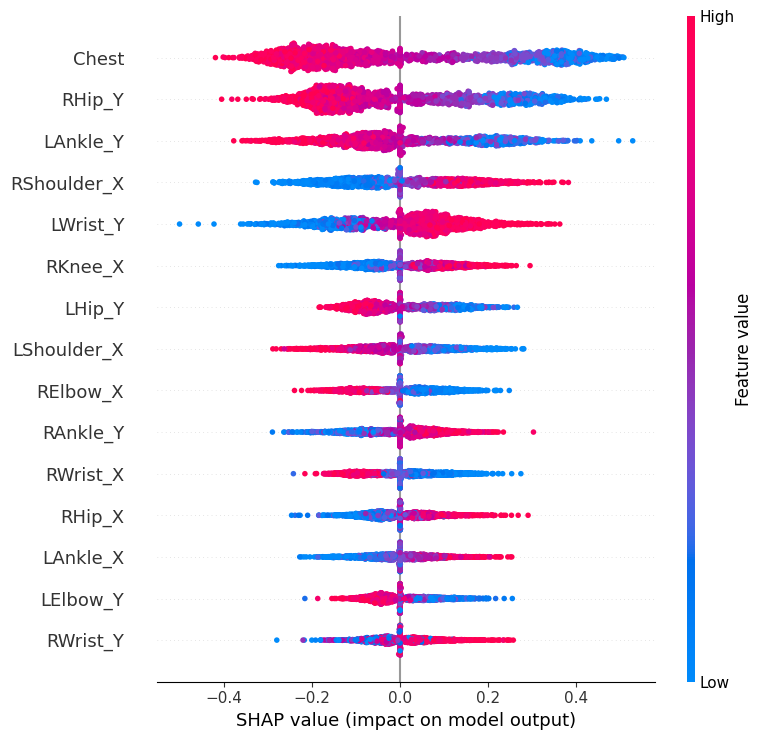

In [41]:
# SHAP 값을 2D 배열로 변환 (마지막 차원 제거)
shap_values_2d = shap_values.reshape(shap_values.shape[0], -1)  # 2D로 변환
X_single_test_2d = X_single_test.reshape(X_single_test.shape[0], -1)


# Summary plot 시각화
shap.summary_plot(shap_values_2d, X_single_test_2d, feature_names=feature_columns, max_display=15)

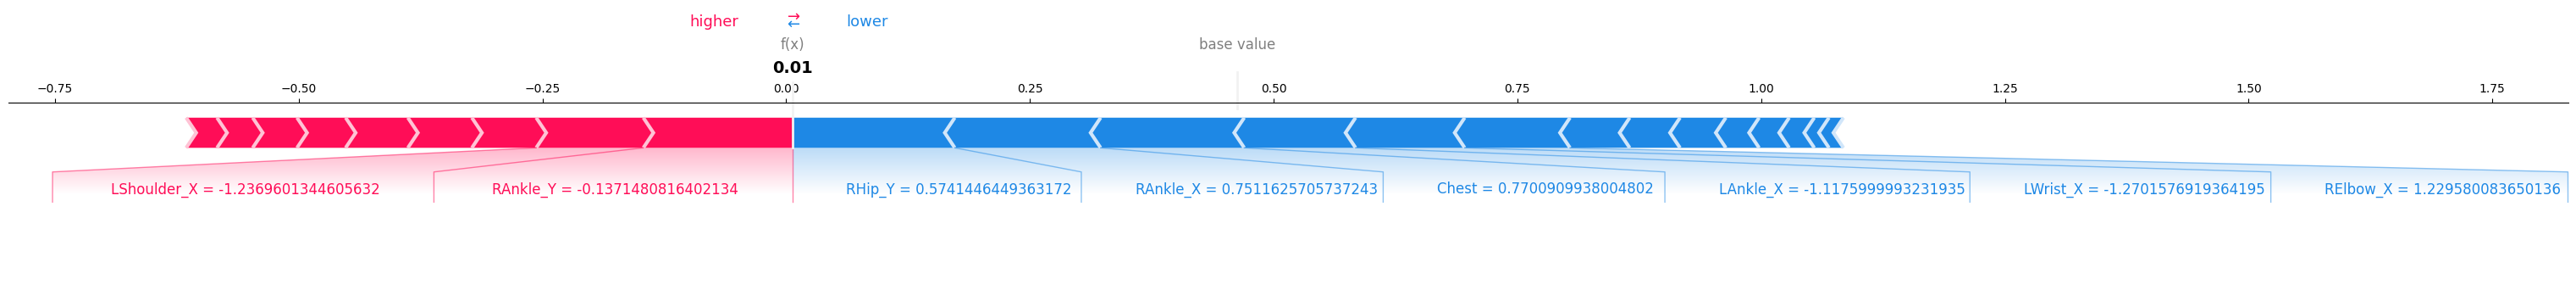

In [35]:
# 첫 번째 샘플에 대한 SHAP 값 및 특성 추출
shap_values_sample = shap_values_2d[3]
X_single_test_sample = X_single_test_2d[3]

# Force plot 시각화 (feature_names 추가)
shap.force_plot(explainer.expected_value, shap_values_sample, X_single_test_sample, 
                 matplotlib=True, figsize=(39, 3), feature_names=feature_columns)